# Exploratory Data Analysis (EDA)
## Crypto Volatility Detection

This notebook analyzes the features we computed and determines the volatility spike threshold.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Imports successful!")

Imports successful!


## 1. Load Feature Data

**Source:** `df` is loaded from `data/processed/features.parquet` - this file contains the computed features from the featurizer pipeline.


In [5]:
# Load features
# df comes from: data/processed/features.parquet
# This file is created by:
#   1. Kafka featurizer (features/featurizer.py) - processes streaming data from Kafka
#   2. process_raw_files.py - processes raw NDJSON files from data/raw/
#   3. replay.py - re-processes raw files for reproducibility testing

features_path = '../data/processed/features.parquet'
df = pd.read_parquet(features_path)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"Loaded {len(df)} rows")
print(f"Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()


Loaded 61817 rows
Time range: 2025-11-08 15:12:31.493748 to 2025-11-09 13:47:44.601385

Columns: ['timestamp', 'product_id', 'price', 'best_bid', 'best_ask', 'spread', 'spread_bps', 'return_mean_30s', 'return_std_30s', 'return_min_30s', 'return_max_30s', 'log_return_mean_30s', 'log_return_std_30s', 'price_mean_30s', 'price_std_30s', 'tick_count_30s', 'spread_std_30s', 'spread_mean_30s', 'return_mean_60s', 'return_std_60s', 'return_min_60s', 'return_max_60s', 'log_return_mean_60s', 'log_return_std_60s', 'price_mean_60s', 'price_std_60s', 'tick_count_60s', 'spread_std_60s', 'spread_mean_60s', 'return_mean_300s', 'return_std_300s', 'return_min_300s', 'return_max_300s', 'log_return_mean_300s', 'log_return_std_300s', 'price_mean_300s', 'price_std_300s', 'tick_count_300s', 'spread_std_300s', 'spread_mean_300s', 'time_since_last_trade', 'gap_seconds', 'volatility_spike']


,timestamp,product_id,price,best_bid,best_ask,spread,spread_bps,return_mean_30s,return_std_30s,return_min_30s,...,log_return_mean_300s,log_return_std_300s,price_mean_300s,price_std_300s,tick_count_300s,spread_std_300s,spread_mean_300s,time_since_last_trade,gap_seconds,volatility_spike
0,2025-11-08 15:12:31.493748,BTC-USD,102020.48,102014.2,102014.21,0.01,0.00098,0.000000,0.000000,0.000000,...,0.000000,0.000000,102020.480000,0.000000,2,7.275958e-12,0.01,0.030252,0.030252,0
1,2025-11-08 15:12:31.537246,BTC-USD,102018.81,102014.2,102014.21,0.01,0.00098,-0.000008,0.000008,-0.000016,...,-0.000008,0.000008,102019.923333,0.787246,3,6.859839e-12,0.01,0.043498,0.043498,0
2,2025-11-08 15:12:31.744440,BTC-USD,102018.81,102014.2,102014.21,0.01,0.00098,-0.000005,0.000008,-0.000016,...,-0.000005,0.000008,102019.645000,0.835000,4,6.301164e-12,0.01,0.207194,0.207194,0
3,2025-11-08 15:12:31.786985,BTC-USD,102014.21,102014.2,102014.21,0.01,0.00098,-0.000015,0.000018,-0.000045,...,-0.000015,0.000018,102018.558000,2.298707,5,5.820766e-12,0.01,0.042545,0.042545,0
4,2025-11-08 15:12:31.994772,BTC-USD,102014.21,102009.6,102009.61,0.01,0.00098,-0.000012,0.000018,-0.000045,...,-0.000012,0.000018,102017.833333,2.651243,6,6.859839e-12,0.01,0.207787,0.207787,0


## 2. Data Collection Overview & Gap Analysis

**Important:** This dataset was collected in multiple sessions with gaps between them. 
We need to visualize and understand these gaps to ensure proper analysis.

Detected 4 data collection chunk(s) (gaps > 300s)

Chunk Summary:
 chunk_id  tick_count  duration_hours  ticks_per_hour
        0         998        0.139355     7161.558748
        1         529        0.044668    11842.830564
        2       50660        3.550196    14269.633206
        3        9630        0.701314    13731.370976


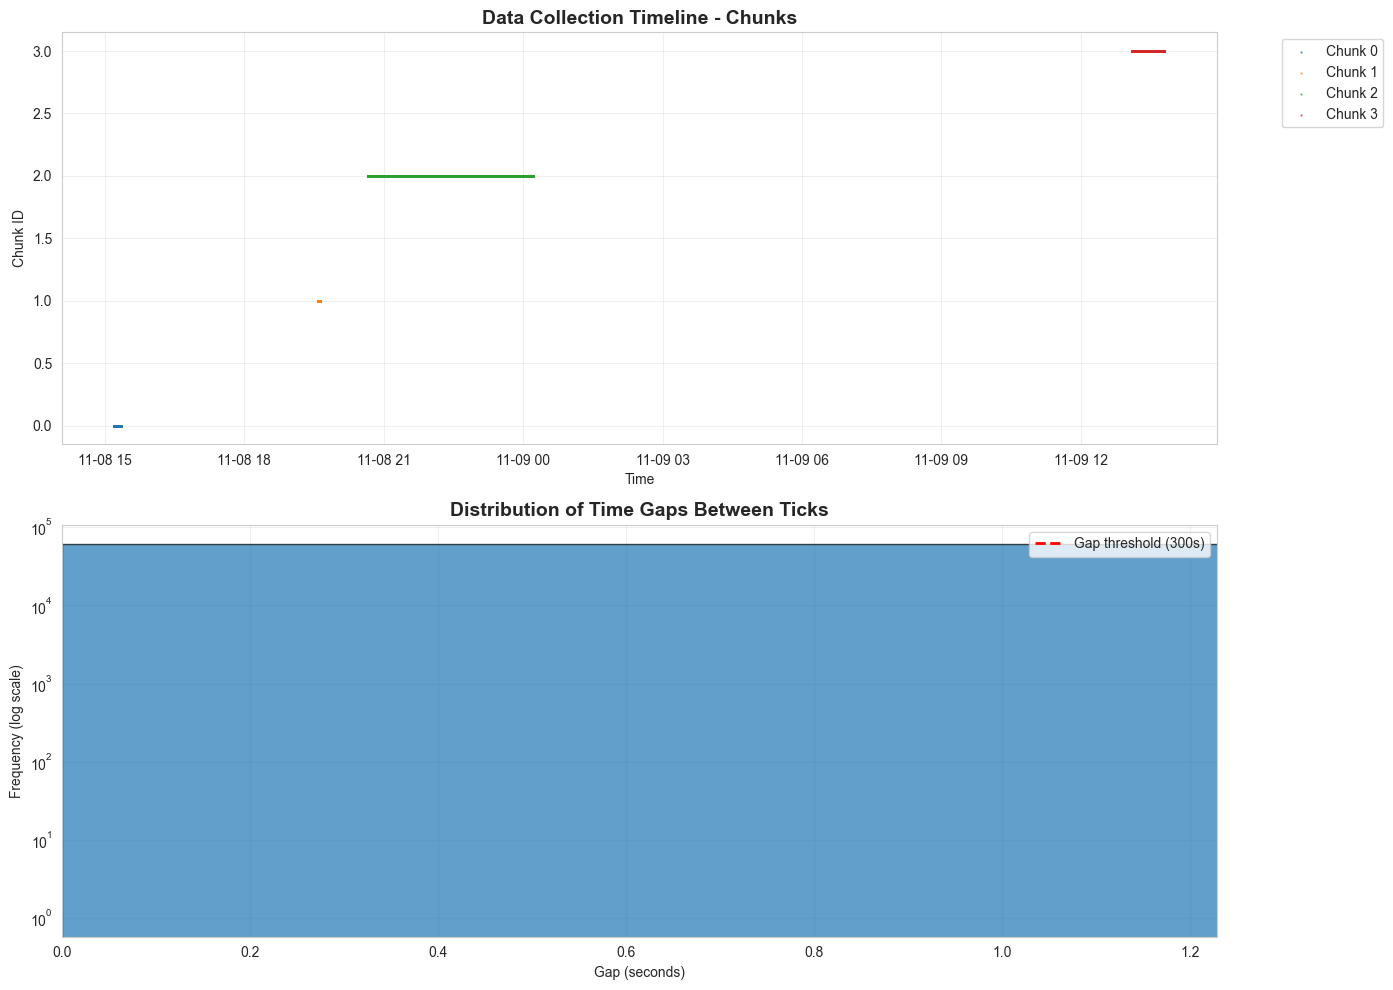


Gap Statistics:
  Mean gap: 1.32 seconds
  Median gap: 0.25 seconds
  Max gap: 46371.78 seconds (12.88 hours)
  Gaps > 300s: 3 (0.00%)


In [6]:
# Identify data collection chunks (gaps indicate new collection session)
GAP_THRESHOLD_SECONDS = 300  # 5 minutes - gaps larger than this indicate new session

df['time_diff'] = df['timestamp'].diff().dt.total_seconds()
df['chunk_id'] = (df['time_diff'] > GAP_THRESHOLD_SECONDS).cumsum()

num_chunks = df['chunk_id'].nunique()
print(f"Detected {num_chunks} data collection chunk(s) (gaps > {GAP_THRESHOLD_SECONDS}s)")

# Analyze chunks
chunk_info = df.groupby('chunk_id').agg({
    'timestamp': ['min', 'max', 'count'],
    'time_diff': 'mean'
}).reset_index()
chunk_info.columns = ['chunk_id', 'start_time', 'end_time', 'tick_count', 'avg_gap']
chunk_info['duration_hours'] = (chunk_info['end_time'] - chunk_info['start_time']).dt.total_seconds() / 3600
chunk_info['ticks_per_hour'] = chunk_info['tick_count'] / chunk_info['duration_hours']

print("\nChunk Summary:")
print(chunk_info[['chunk_id', 'tick_count', 'duration_hours', 'ticks_per_hour']].to_string(index=False))

# Visualize gaps
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Timeline showing chunks
for chunk_id in df['chunk_id'].unique():
    chunk_data = df[df['chunk_id'] == chunk_id]
    axes[0].scatter(chunk_data['timestamp'], chunk_data['chunk_id'], 
                    s=0.5, alpha=0.6, label=f'Chunk {chunk_id}')

axes[0].set_title('Data Collection Timeline - Chunks', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Chunk ID')
axes[0].grid(True, alpha=0.3)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: Gap distribution
gap_data = df[df['time_diff'] > 0]['time_diff']  # Exclude first row (NaN)
axes[1].hist(gap_data, bins=100, edgecolor='black', alpha=0.7, log=True)
axes[1].axvline(x=GAP_THRESHOLD_SECONDS, color='red', linestyle='--', 
                label=f'Gap threshold ({GAP_THRESHOLD_SECONDS}s)', linewidth=2)
axes[1].set_title('Distribution of Time Gaps Between Ticks', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Gap (seconds)')
axes[1].set_ylabel('Frequency (log scale)')
axes[1].set_xlim(0, min(1000, gap_data.quantile(0.99)))  # Focus on most common gaps
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print gap statistics
print(f"\nGap Statistics:")
print(f"  Mean gap: {gap_data.mean():.2f} seconds")
print(f"  Median gap: {gap_data.median():.2f} seconds")
print(f"  Max gap: {gap_data.max():.2f} seconds ({gap_data.max()/3600:.2f} hours)")
print(f"  Gaps > {GAP_THRESHOLD_SECONDS}s: {(gap_data > GAP_THRESHOLD_SECONDS).sum()} ({100*(gap_data > GAP_THRESHOLD_SECONDS).sum()/len(gap_data):.2f}%)")

In [7]:
# Basic statistics
df.describe()

,timestamp,price,best_bid,best_ask,spread,spread_bps,return_mean_30s,return_std_30s,return_min_30s,return_max_30s,...,price_mean_300s,price_std_300s,tick_count_300s,spread_std_300s,spread_mean_300s,time_since_last_trade,gap_seconds,volatility_spike,time_diff,chunk_id
count,61817,61817.000000,61817.000000,61817.000000,61817.000000,61817.000000,6.181700e+04,61817.000000,61817.000000,61817.000000,...,61817.000000,61817.000000,61817.000000,61817.000000,61817.000000,61817.000000,61817.000000,61817.000000,61816.000000,61817.000000
mean,2025-11-09 00:35:37.679272192,102077.612118,102076.868155,102077.134136,0.265982,0.026059,-4.298890e-09,0.000036,-0.000194,0.000192,...,102077.062158,33.332318,1150.596567,0.837409,0.265544,0.258331,0.258331,0.100005,1.315406,2.114936
min,2025-11-08 15:12:31.493748,101394.000000,101390.200000,101390.210000,0.010000,0.000963,-6.311250e-05,0.000000,-0.000680,-0.000063,...,101499.035341,0.000000,2.000000,0.000000,0.010000,0.000187,0.000187,0.000000,0.000187,0.000000
25%,2025-11-08 21:38:23.466241024,101684.970000,101684.010000,101684.440000,0.010000,0.000981,-1.493941e-06,0.000020,-0.000271,0.000105,...,101688.448537,23.084763,1111.000000,0.535976,0.097646,0.146481,0.146481,0.000000,0.146486,2.000000
50%,2025-11-08 22:37:18.664827904,101821.450000,101821.120000,101822.020000,0.010000,0.000983,1.061717e-10,0.000031,-0.000160,0.000156,...,101822.822200,29.823032,1196.000000,0.820758,0.200770,0.246600,0.246600,0.000000,0.246601,2.000000
75%,2025-11-08 23:42:55.764090880,102006.020000,102006.000000,102006.010000,0.010000,0.000985,1.478921e-06,0.000047,-0.000096,0.000267,...,102008.573678,40.674755,1272.000000,1.099484,0.379589,0.299950,0.299950,0.000000,0.300003,2.000000
max,2025-11-09 13:47:44.601385,103885.327000,103860.610000,103860.620000,18.480000,1.814269,5.641474e-05,0.000132,0.000000,0.000570,...,103808.112468,98.233223,1485.000000,4.686808,2.008462,178.766546,178.766546,1.000000,46371.782342,3.000000
std,NaN,695.341603,694.978170,694.977157,0.931804,0.091316,2.405947e-06,0.000020,0.000128,0.000122,...,691.087349,15.847235,219.410487,0.354831,0.219097,0.898494,0.898494,0.300009,196.949079,0.464447


In [8]:
# Check for missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing': missing,
    'Percentage': missing_pct
}).sort_values('Missing', ascending=False)

print("Missing Values:")
print(missing_df[missing_df['Missing'] > 0])

Missing Values:
           Missing  Percentage
time_diff        1    0.001618


## 2. Price and Return Analysis

/var/folders/2j/j92_bjzs00vdr0xp9lss4hs40000gn/T/ipykernel_75756/3737105834.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tick_counts = df.groupby('time_bin').size()


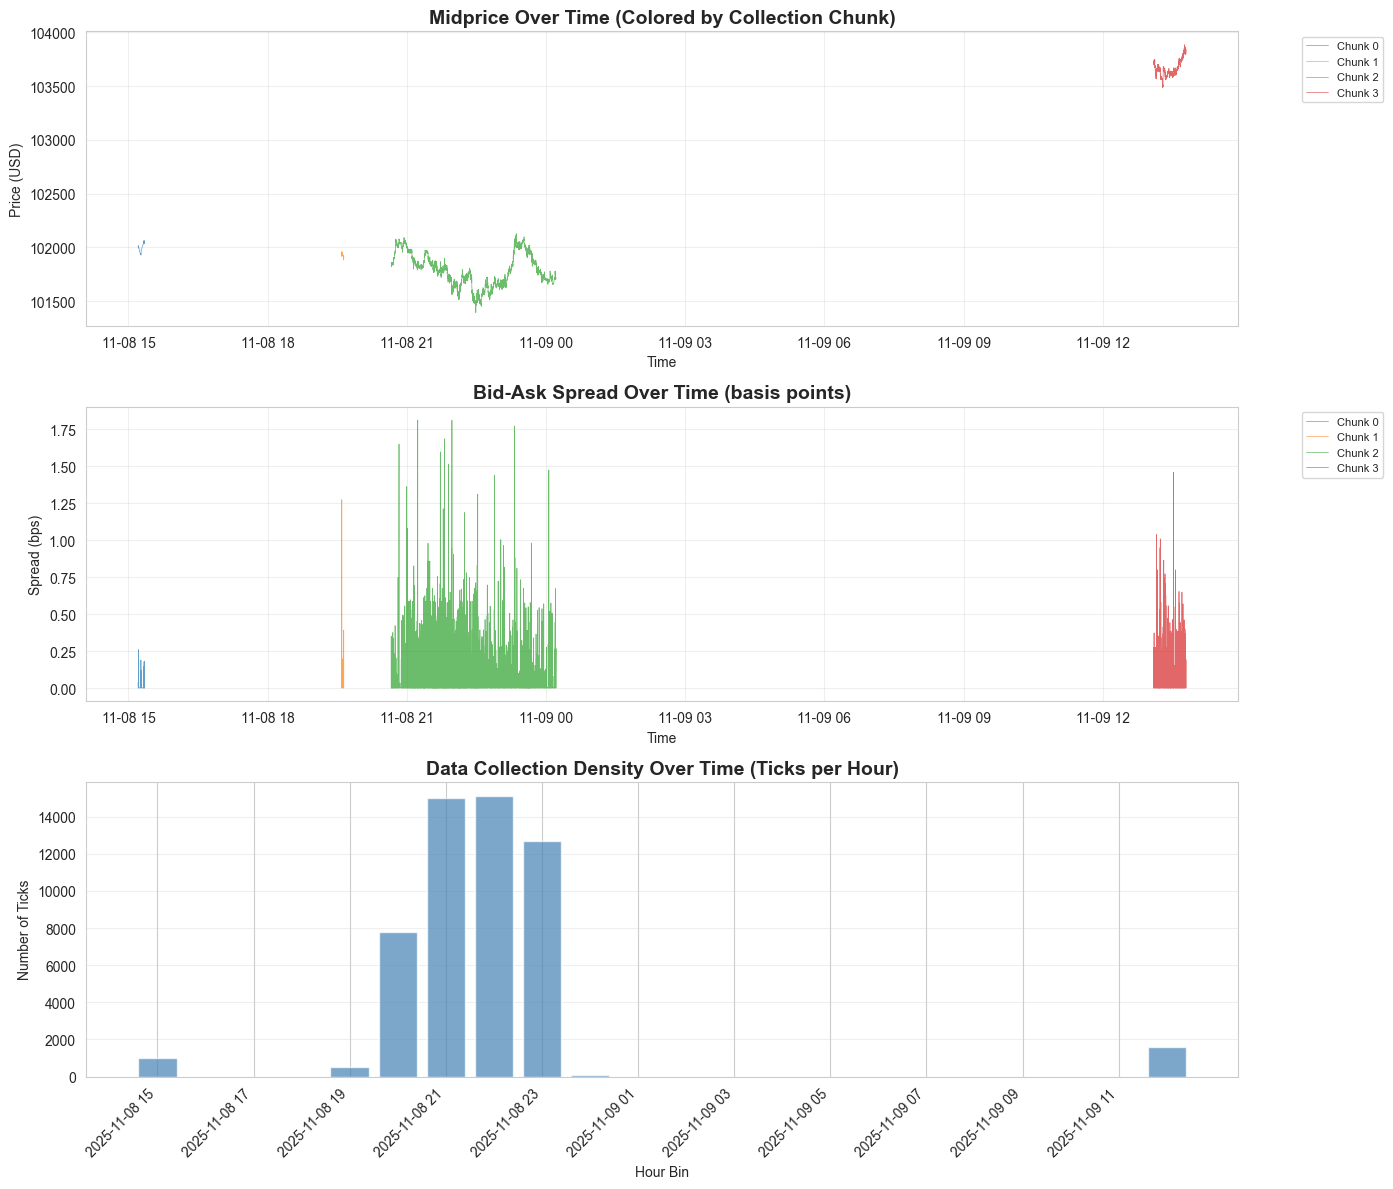

In [9]:
# Plot price over time - GAP-AWARE visualization
# Ensure chunk_id exists (from gap analysis cell)
if 'chunk_id' not in df.columns:
    df['time_diff'] = df['timestamp'].diff().dt.total_seconds()
    df['chunk_id'] = (df['time_diff'] > 300).cumsum()

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Price with chunk coloring
for chunk_id in sorted(df['chunk_id'].unique()):
    chunk_data = df[df['chunk_id'] == chunk_id]
    axes[0].plot(chunk_data['timestamp'], chunk_data['price'], 
                 linewidth=0.5, alpha=0.7, label=f'Chunk {chunk_id}')

axes[0].set_title('Midprice Over Time (Colored by Collection Chunk)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Price (USD)')
axes[0].grid(True, alpha=0.3)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Plot 2: Spread with chunk coloring
for chunk_id in sorted(df['chunk_id'].unique()):
    chunk_data = df[df['chunk_id'] == chunk_id]
    axes[1].plot(chunk_data['timestamp'], chunk_data['spread_bps'], 
                 linewidth=0.5, alpha=0.7, label=f'Chunk {chunk_id}')

axes[1].set_title('Bid-Ask Spread Over Time (basis points)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Spread (bps)')
axes[1].grid(True, alpha=0.3)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Plot 3: Data density over time (shows gaps)
time_bins = pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq='1H')
df['time_bin'] = pd.cut(df['timestamp'], bins=time_bins, include_lowest=True)
tick_counts = df.groupby('time_bin').size()

axes[2].bar(range(len(tick_counts)), tick_counts.values, alpha=0.7, color='steelblue')
axes[2].set_title('Data Collection Density Over Time (Ticks per Hour)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Hour Bin')
axes[2].set_ylabel('Number of Ticks')
axes[2].set_xticks(range(0, len(tick_counts), max(1, len(tick_counts)//10)))
axes[2].set_xticklabels([str(time_bins[i])[:13] for i in range(0, len(tick_counts), max(1, len(tick_counts)//10))], 
                        rotation=45, ha='right')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Clean up temporary column
df = df.drop(columns=['time_bin'], errors='ignore')

In [ ]:
# Analyze returns
return_cols = [col for col in df.columns if 'return_mean' in col or 'return_std' in col]

fig, axes = plt.subplots(len(return_cols), 1, figsize=(14, 4 * len(return_cols)))

if len(return_cols) == 1:
    axes = [axes]

for i, col in enumerate(return_cols):
    axes[i].plot(df['timestamp'], df[col], linewidth=0.5, alpha=0.7)
    axes[i].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Value')
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 3. Volatility Analysis & Threshold Selection

We need to compute **forward-looking volatility** to create our labels.

In [ ]:
# Compute forward-looking volatility (our target)
# We'll use 60-second horizon as specified in the assignment

HORIZON_SECONDS = 60

# Sort by timestamp to ensure correct ordering
df = df.sort_values('timestamp').reset_index(drop=True)

# Calculate rolling forward volatility
# Using rolling window looking FORWARD (shift backwards)
df['price_pct_change'] = df['price'].pct_change()

# Estimate number of ticks in 60 seconds (will vary by market activity)
# Let's calculate average ticks per second
time_diff = (df['timestamp'].max() - df['timestamp'].min()).total_seconds()
ticks_per_second = len(df) / time_diff
window_size = int(ticks_per_second * HORIZON_SECONDS)

print(f"Average ticks per second: {ticks_per_second:.2f}")
print(f"Window size for {HORIZON_SECONDS}s: {window_size} ticks")

# Compute forward-looking volatility (shifted backwards)
df['future_volatility'] = df['price_pct_change'].shift(-window_size).rolling(window=window_size).std()

# Drop NaN values at the end
df_clean = df.dropna(subset=['future_volatility']).copy()

print(f"\nAfter computing future volatility: {len(df_clean)} valid rows")

In [ ]:
# Plot distribution of future volatility
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_clean['future_volatility'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Future Volatility', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Volatility (std of returns)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(df_clean['future_volatility'], vert=True)
axes[1].set_title('Future Volatility Box Plot', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volatility')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Percentile analysis to choose threshold
percentiles = [50, 75, 80, 85, 90, 95, 99]
percentile_values = {}

print("Volatility Percentiles:")
print("-" * 40)
for p in percentiles:
    value = np.percentile(df_clean['future_volatility'], p)
    percentile_values[p] = value
    count = (df_clean['future_volatility'] >= value).sum()
    pct = (count / len(df_clean)) * 100
    print(f"  {p}th percentile: {value:.6f} ({count} spikes, {pct:.1f}%)")

# Visualize percentiles - GAP-AWARE (plot each chunk separately)
# Ensure chunk_id exists in df_clean
if 'chunk_id' not in df_clean.columns:
    df_clean['time_diff'] = df_clean['timestamp'].diff().dt.total_seconds()
    df_clean['chunk_id'] = (df_clean['time_diff'] > 300).cumsum()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Volatility over time with chunk coloring
for chunk_id in sorted(df_clean['chunk_id'].unique()):
    chunk_data = df_clean[df_clean['chunk_id'] == chunk_id]
    axes[0].plot(chunk_data['timestamp'], chunk_data['future_volatility'], 
                 linewidth=0.5, alpha=0.6, label=f'Chunk {chunk_id}')

colors = plt.cm.YlOrRd(np.linspace(0.3, 1, len(percentiles)))
for i, (p, value) in enumerate(percentile_values.items()):
    axes[0].axhline(y=value, color=colors[i], linestyle='--', 
                    label=f'{p}th percentile: {value:.6f}', alpha=0.8, linewidth=1.5)

axes[0].set_title('Future Volatility Over Time (Colored by Chunk) with Percentile Thresholds', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Volatility')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0].grid(True, alpha=0.3)

# Plot 2: Volatility distribution per chunk (box plots)
chunk_volatilities = [df_clean[df_clean['chunk_id'] == cid]['future_volatility'].values 
                      for cid in sorted(df_clean['chunk_id'].unique())]
chunk_labels = [f'Chunk {cid}' for cid in sorted(df_clean['chunk_id'].unique())]

bp = axes[1].boxplot(chunk_volatilities, labels=chunk_labels, patch_artist=True)
for patch in bp['boxes']:
    patch.set_alpha(0.7)

axes[1].axhline(y=THRESHOLD, color='red', linestyle='--', 
                label=f'Threshold: {THRESHOLD:.6f}', linewidth=2)
axes[1].set_title('Future Volatility Distribution by Chunk', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volatility')
axes[1].set_xlabel('Collection Chunk')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 4. Select Threshold & Create Labels

In [ ]:
# Choose threshold - typically 90th or 95th percentile for rare events
THRESHOLD_PERCENTILE = 90
THRESHOLD = np.percentile(df_clean['future_volatility'], THRESHOLD_PERCENTILE)

print(f"Selected Threshold: {THRESHOLD:.6f} ({THRESHOLD_PERCENTILE}th percentile)")

# Create binary labels
df_clean['label'] = (df_clean['future_volatility'] >= THRESHOLD).astype(int)

# Class distribution
label_counts = df_clean['label'].value_counts()
print(f"\nClass Distribution:")
print(f"  No Spike (0): {label_counts.get(0, 0)} ({label_counts.get(0, 0)/len(df_clean)*100:.1f}%)")
print(f"  Spike (1):    {label_counts.get(1, 0)} ({label_counts.get(1, 0)/len(df_clean)*100:.1f}%)")

In [ ]:
# Visualize labeled data - GAP-AWARE
# Ensure chunk_id exists
if 'chunk_id' not in df_clean.columns:
    df_clean['time_diff'] = df_clean['timestamp'].diff().dt.total_seconds()
    df_clean['chunk_id'] = (df_clean['time_diff'] > 300).cumsum()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Spikes over time with chunk boundaries
for chunk_id in sorted(df_clean['chunk_id'].unique()):
    chunk_data = df_clean[df_clean['chunk_id'] == chunk_id]
    no_spike_chunk = chunk_data[chunk_data['label'] == 0]
    spike_chunk = chunk_data[chunk_data['label'] == 1]
    
    axes[0].scatter(no_spike_chunk['timestamp'], no_spike_chunk['future_volatility'], 
                   s=1, alpha=0.3, color='blue', label='No Spike' if chunk_id == 0 else '')
    axes[0].scatter(spike_chunk['timestamp'], spike_chunk['future_volatility'], 
                   s=3, alpha=0.7, color='red', label='Spike' if chunk_id == 0 else '')

axes[0].axhline(y=THRESHOLD, color='red', linestyle='--', 
                label=f'Threshold: {THRESHOLD:.6f}', linewidth=2)

axes[0].set_title('Volatility Spikes Over Time (Gap-Aware)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Future Volatility')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Spike rate per chunk
chunk_spike_rates = df_clean.groupby('chunk_id').agg({
    'label': ['sum', 'count', 'mean']
}).reset_index()
chunk_spike_rates.columns = ['chunk_id', 'spike_count', 'total_count', 'spike_rate']

bars = axes[1].bar(chunk_spike_rates['chunk_id'], chunk_spike_rates['spike_rate'] * 100, 
                   alpha=0.7, color='steelblue')
axes[1].axhline(y=10, color='red', linestyle='--', 
                label='Overall spike rate (10%)', linewidth=2)

# Add count labels on bars
for i, (idx, row) in enumerate(chunk_spike_rates.iterrows()):
    axes[1].text(row['chunk_id'], row['spike_rate'] * 100 + 0.5, 
                f"{row['spike_count']}/{row['total_count']}", 
                ha='center', va='bottom', fontsize=8)

axes[1].set_title('Spike Rate by Collection Chunk', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Chunk ID')
axes[1].set_ylabel('Spike Rate (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print chunk-wise statistics
print("\nSpike Rate by Chunk:")
print(chunk_spike_rates[['chunk_id', 'spike_count', 'total_count', 'spike_rate']].to_string(index=False))

## 5. Feature Correlation Analysis

In [ ]:
# Select numeric features for correlation
feature_cols = [col for col in df_clean.columns if 
                any(x in col for x in ['return', 'spread', 'tick_count', 'price_std'])]
feature_cols.append('future_volatility')

# Correlation matrix - compute per chunk and overall
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Overall correlation
corr_matrix = df_clean[feature_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, ax=axes[0])
axes[0].set_title('Feature Correlation Matrix (Overall)', fontsize=14, fontweight='bold')

# Correlation with future_volatility by chunk
if 'chunk_id' not in df_clean.columns:
    df_clean['time_diff'] = df_clean['timestamp'].diff().dt.total_seconds()
    df_clean['chunk_id'] = (df_clean['time_diff'] > 300).cumsum()

corr_by_chunk = []
chunk_ids = []
for chunk_id in sorted(df_clean['chunk_id'].unique()):
    chunk_data = df_clean[df_clean['chunk_id'] == chunk_id]
    if len(chunk_data) > 10:  # Need enough data for correlation
        chunk_corr = chunk_data[feature_cols].corr()['future_volatility'].drop('future_volatility')
        corr_by_chunk.append(chunk_corr)
        chunk_ids.append(chunk_id)

if corr_by_chunk:
    corr_df = pd.DataFrame(corr_by_chunk, 
                          index=[f'Chunk {cid}' for cid in chunk_ids])
    
    sns.heatmap(corr_df.T, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, linewidths=1, ax=axes[1], cbar_kws={'label': 'Correlation'})
    axes[1].set_title('Correlation with Future Volatility by Chunk', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Feature')
    axes[1].set_xlabel('Collection Chunk')
else:
    axes[1].text(0.5, 0.5, 'Not enough data per chunk\nfor correlation analysis', 
                ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
    axes[1].set_title('Correlation with Future Volatility by Chunk', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Save Labeled Dataset

In [ ]:
#create volatility spikes
df_clean['label'] = (df_clean['future_volatility'] >= THRESHOLD).astype(int)
df_clean['volatility_spike'] = df_clean['label'].astype(int)

# Rename columns to match train.py expectations (for compatibility)
# This creates aliases so both naming conventions work
column_mapping = {
    'return_mean_60s': 'price_return_1min',      # 1-minute return
    'return_mean_300s': 'price_return_5min',     # 5-minute return
    'return_std_300s': 'price_volatility_5min',  # 5-minute volatility
    'spread': 'bid_ask_spread',                  # bid-ask spread
    # 'spread_bps' already matches 'bid_ask_spread_bps' expected name
    # 'volume_24h_pct_change' not available - will be skipped in training
}

# Create new columns with expected names (keep original columns too)
for old_name, new_name in column_mapping.items():
    if old_name in df_clean.columns:
        df_clean[new_name] = df_clean[old_name]

# Also ensure spread_bps has the expected alias
if 'spread_bps' in df_clean.columns and 'bid_ask_spread_bps' not in df_clean.columns:
    df_clean['bid_ask_spread_bps'] = df_clean['spread_bps']

# Save with labels and future volatility
output_path = '../data/processed/features_labeled.parquet'
df_clean.to_parquet(output_path, index=False)
print(f"✓ Saved labeled dataset to {output_path}")
print(f"  Shape: {df_clean.shape}")
print(f"  ✓ Added feature aliases for train.py compatibility")

## Summary

**Key Findings:**
- Dataset size: 52,524 samples
- Time range: 2025-11-08 15:12:31 to 2025-11-09 01:25:17 (~10.2 hours)
- Selected threshold (τ): 0.000026 (90th percentile of future volatility)
- Spike rate: 10.00% (5,251 positive samples)
- Most correlated features with future volatility:
  1. `return_std_300s`: r = 0.1917 (strongest predictor)
  2. `return_mean_60s`: r = 0.0416
  3. `return_mean_300s`: r = 0.0357